<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/07-autoencoding-and-self-supervision/01_pca_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PCA Autoencoder

In this notebook, we shows that bread-andbutter
principal component analysis (PCA) works by secretly being an autoencoder.

We’ll make small changes to a PyTorch version of PCA to change it into a fully fledged
autoencoding neural network. 

As we make an autoencoding network larger, it becomes
more important to constrain it well, which we demonstrate with the denoising strategy.

Finally we apply these concepts to sequential models like RNNs, which gives the autoregressive model.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, View, weight_reset, set_seed

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Now we want to create a wrapper for the MNIST datasets. 

Why? Because the default MNIST dataset will return data in pairs `(x, y)` for the input and label, respectively. 

But in our case, the input is the label because we are trying to predict the output from the input.

So we extend the PyTorch Dataset class to take the original tuple `x, y` and instead return a tuple `x, x`.

In [6]:
class AutoEncoderDataset(Dataset):
  """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs."""
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset.__getitem__(idx)
    # just throw away the original label.
    return x, x

In [ ]:
B = 128

train_data = AutoEncoderDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncoderDataset(test_data_xy)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data_xx, batch_size=B)

##PCA encoder and decoder

Let’s define some basic hyperparameters.

In [8]:
D = 28 * 28       # input size
n = 2             # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

Let's define `TransposeLinear` layer that will implement the Transpose
operation $W^T$. 

The matrix to transpose $W$ must be passed in as the `linear_layer` in the
constructor. 

This way, we can share weights between an original `nn.Linear` layer and
this transposed version of that layer.

In [9]:
class TransposeLinear(nn.Module):
  def __init__(self, linear_layer, bias=True):
    """
    linearLayer: is the layer that we want to use the transpose of to produce the output of this layer. 
                  So the Linear layer represents W, and this layer represents W^T. 
                  This is accomplished via weight sharing by re-using the weights of linearLayer
    bias: if True, we will crease a new bias term b that is learned separately from what is in linearLayer. 
          If false, we will not use any bias vector
    """
    super().__init__()

    # create a new variable weight to store a _reference_ to the original weight term.
    self.weight = linear_layer.weight

    if bias:
      # create a new bias vector
      self.bias = nn.Parameter(torch.Tensor(linear_layer.weight.shape[1]))
    else:
      # So if we want the bias term to exist, but be  potentially unused
      self.register_parameter("bias", None)

  def forward(self, x):
    # performs a linear transform when given an input (we use the transpose of our weights) and a bias (if None, it knows to not do anything)
    return F.linear(x, self.weight.t(), self.bias)

Note that because the input comes in as an image with shape `(B, 1, 28, 28)`, and we
are using linear layers, we first need to flatten the input into a vector of shape `(B, 28*28)`.

But in the decode step, we want to have the same shape as the original data.

In [ ]:
# Since we will share the weights of the linear layer, lets define it separately


We use our new train_network function to train all of the models.

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
cnn_results = train_network(cnn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,17.662564,0.633577,0.461121,0.766650,0.837750
1,1,24.730848,0.434101,0.413325,0.845150,0.849067
2,2,31.854846,0.391224,0.358891,0.857450,0.867400
3,3,39.078011,0.363648,0.327916,0.868283,0.877617
4,4,46.151029,0.346689,0.332774,0.873750,0.883317


In [ ]:
cnn_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,17.242578,0.491520,0.315718,0.82165,0.885933
1,1,33.101626,0.320271,0.300401,0.88580,0.892483
2,2,48.030215,0.283402,0.227856,0.90060,0.918867
3,3,61.671954,0.256085,0.238842,0.90905,0.912200
4,4,74.753444,0.246041,0.245748,0.91435,0.917450


Let’s be explicit and tell Python we are finished so we can get back the GPU memory.

In [ ]:
del fc_model
del cnn_model

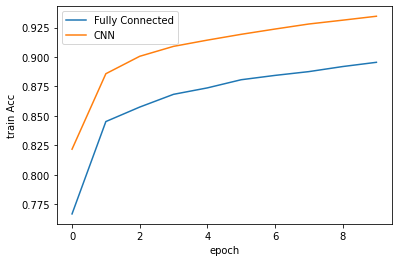

In [ ]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="train Acc", data=cnn_results, label="CNN")

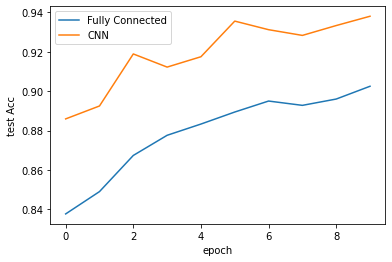

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")

##ReLU Baseline

In [ ]:
# How much I want the LeakyReLU to "leak" by. Anything in [0.01, 0.3] would have been fine.
leak_rate = 0.1

fc_relu_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [ ]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.LeakyReLU(leak_rate)
  )

In [ ]:
cnn_relu_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
fc_relu_results = train_network(fc_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_relu_model

In [ ]:
cnn_relu_results = train_network(cnn_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_relu_model

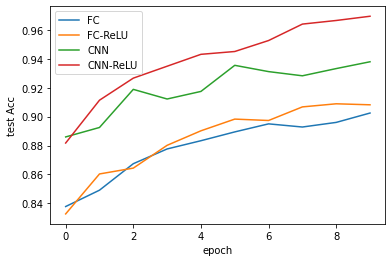

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="FC")
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")

##Batch Normalization Baseline

In [ ]:
fc_bn_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D, n), 
  nn.BatchNorm1d(n),
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n, n), nn.BatchNorm1d(n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [ ]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.BatchNorm2d(out_filters),  # The only change: adding BatchNorm2d after our convolution
    nn.LeakyReLU(leak_rate)
  )

In [ ]:
cnn_bn_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We are ready to train both models.

In [ ]:
fc_bn_results = train_network(fc_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_bn_model

In [ ]:
cnn_bn_results = train_network(cnn_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_bn_model

Let’s compare it with baseline model.

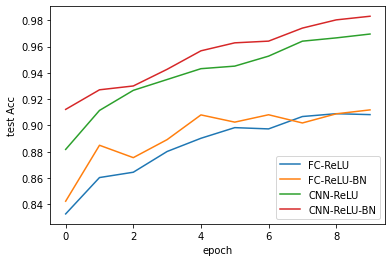

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=fc_bn_results, label="FC-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")

##Residual connections

If we combine skip connections and $1x1$ convolutions in just the right way, we get an approach called a **residual connection**
that converges faster to more accurate solutions.

The first connection type is a residual block. The block is a kind of
skip connection where two layers combine at the end, creating long and short paths.

However, in a residual block, the short path has no operations. We simply leave the input
unaltered!

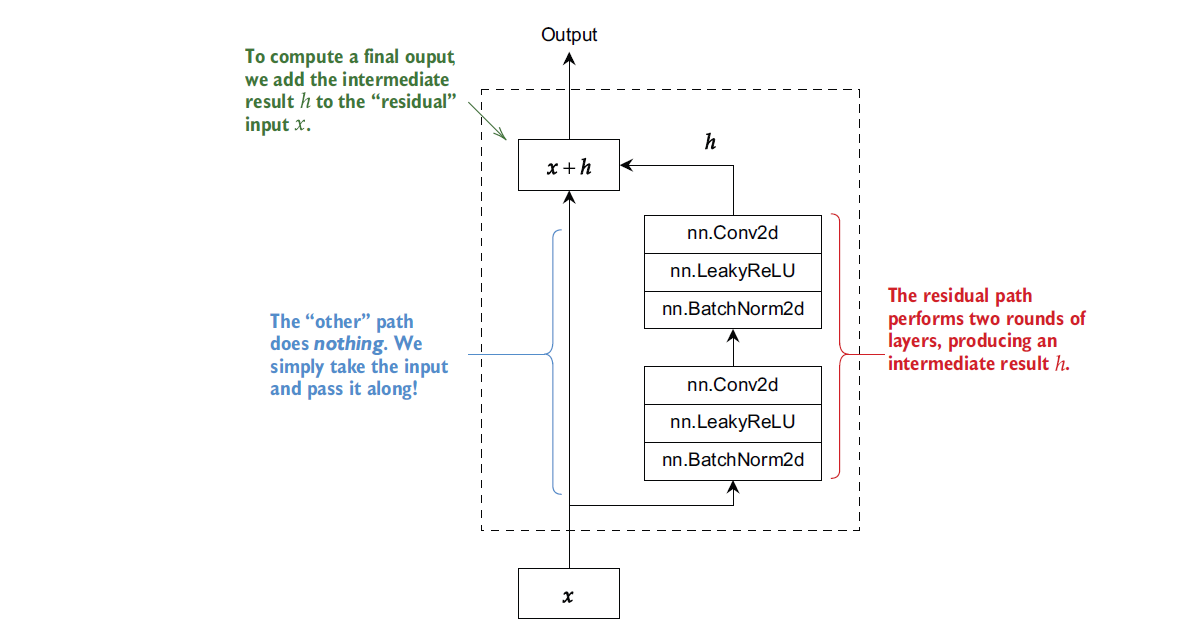

When we start combining multiple residual blocks one after another, we create an
architecture with a very interesting design. You can see, where we end
up with a long path and a short path through the network. The short path makes it easier
to learn deep architectures by having as few operations as possible. 

Fewer operations
means less chance of noise in the gradient, making it easy to propagate a useful gradient
back farther than would otherwise be possible. 

The long path then performs the actual
work, learning units of complexity that are added back in via the skip connections (using
addition instead of concatenation).

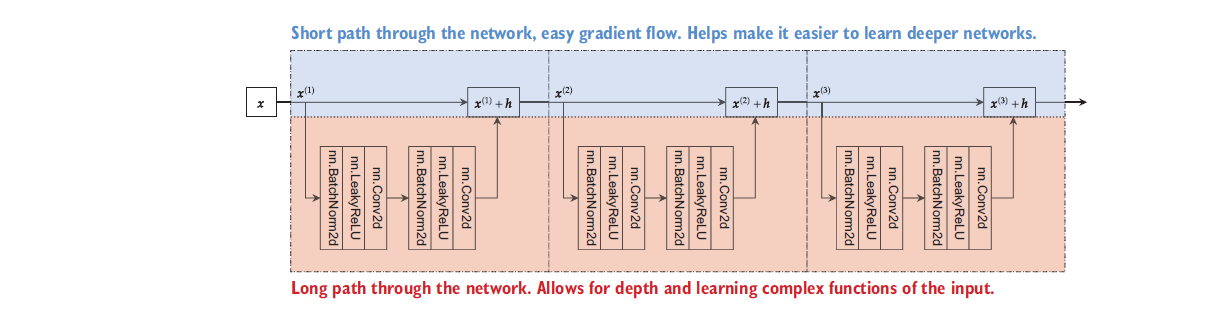

###Residual blocks

The residual block requires that the input and output have the
exact same shape because we are using addition instead of concatenation. 

This is where
the bottleneck layer helps.

The residual block we have described is called Type E and is one of the favored residual
setups.

In [ ]:
class ResidualBlockE(nn.Module):
  def __init__(self, channels, kernel_size=3, leak_rate=0.1):
    super().__init__()
    # how much padding will our convolutional layers need to maintain the input shape
    pad = (kernel_size - 1) // 2

    # Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
    self.F = nn.Sequential(
      nn.Conv2d(channels, channels, kernel_size, padding=pad),
      nn.BatchNorm2d(channels),
      nn.LeakyReLU(leak_rate),

      nn.Conv2d(channels, channels, kernel_size, padding=pad),
      nn.BatchNorm2d(channels),
      nn.LeakyReLU(leak_rate),
    )

  def forward(self, x):
    # combine the long path and short path
    return x + self.F(x)

###Residual bottlenecks

The residual layer is a simple extension of the skip connection idea that works by making
the short path do as little work as possible to help with the gradient flow and minimize
noise. 

But we need a way to handle different numbers of channels after we do pooling.

The solution is `1 x 1` convolutions. We can use the `1 x 1` layer to do the minimum
amount of work to simply change the number of channels in the input, increasing or
decreasing the number of channels as we see fit. The preferred approach is to create a residual bottleneck.

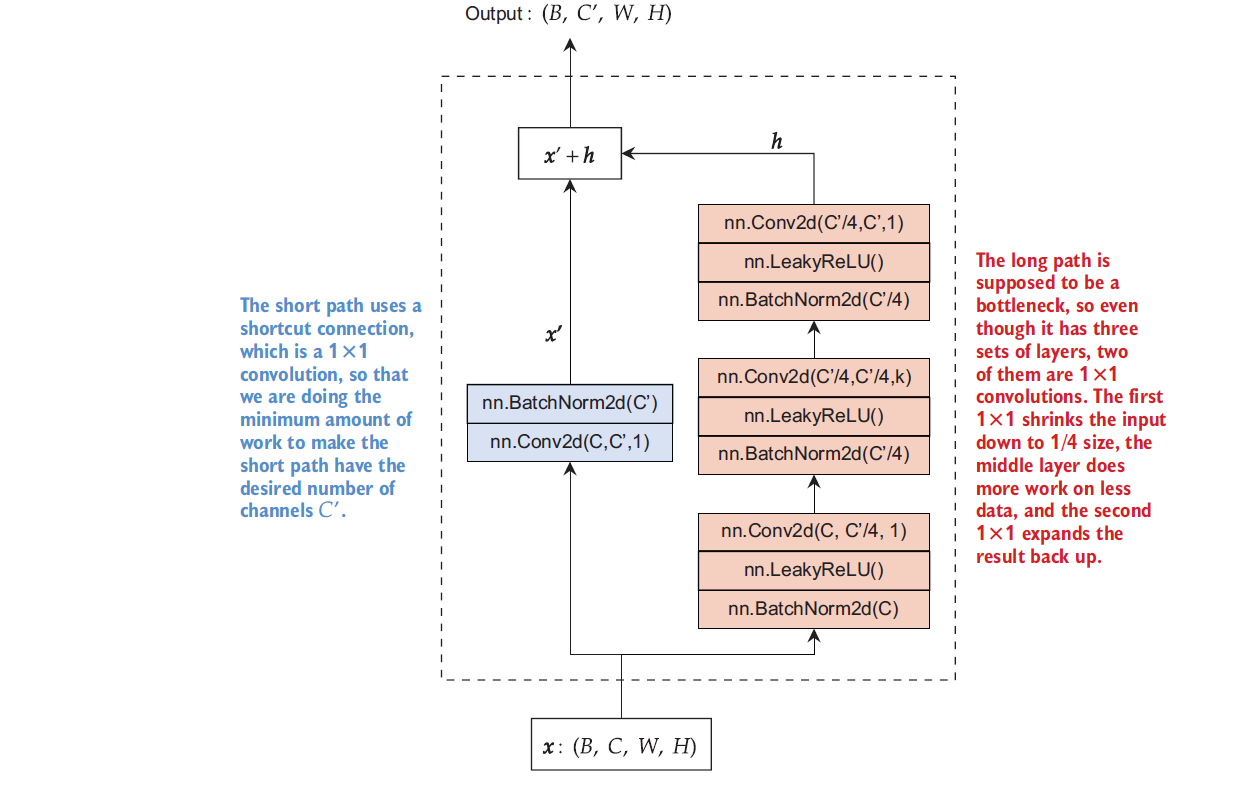

The idea is that if you force a model to go from a large number of
parameters to a small number, you force the model to create more meaningful and
compact representations.

We do this with a little trick: if the bottleneck is not changing the number of channels,
we use the Identity function to implement it. This function simply returns the input
as the output. If the number of channels does change, we override the definition with a
small nn.Sequential that does the `1 x 1` followed by BN.

In [ ]:
class ResidualBottleNeck(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
    super().__init__()
    # how much padding will our convolutional layers need to maintain the input shape
    pad = (kernel_size - 1) // 2
    # The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue.
    bottleneck = max(out_channels // 4, in_channels)

    #Define the three sets of BN and convolution layers we need. 
    #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
    self.F = nn.Sequential(
      # Compress down
      nn.BatchNorm2d(in_channels),
      nn.LeakyReLU(leak_rate),
      nn.Conv2d(in_channels, bottleneck, 1, padding=0),

      # Normal layer doing a full conv
      nn.BatchNorm2d(bottleneck),
      nn.LeakyReLU(leak_rate),
      nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),

      # Expand back up
      nn.BatchNorm2d(bottleneck),
      nn.LeakyReLU(leak_rate),
      nn.Conv2d(bottleneck, out_channels, 1, padding=0)
    )

    # By default, our shortcut will be the identiy function - which simply returns the input as the output
    self.shortcut = nn.Identity()

    # If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
    if in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, padding=0),
        nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    # combine the long path and short path
    return self.shortcut(x) + self.F(x)

In [ ]:
cnn_res_model = nn.Sequential(
  # BottleNeck to start because we need more channels. Its also common to start with just one normal hidden layer before beginning residual blocks
  ResidualBottleNeck(C, n_filters),
  nn.LeakyReLU(leak_rate),          # We are inserting a activation after each residual. This is optional. 
  ResidualBlockE(n_filters),
  nn.LeakyReLU(leak_rate),
  nn.MaxPool2d((2,2)),
  
  ResidualBottleNeck(n_filters, 2 * n_filters),
  nn.LeakyReLU(leak_rate),
  ResidualBlockE(2 * n_filters),
  nn.LeakyReLU(leak_rate),
  nn.MaxPool2d((2,2)),

  ResidualBottleNeck(2 * n_filters, 4 * n_filters),
  nn.LeakyReLU(leak_rate),
  ResidualBlockE(4 * n_filters),
  nn.LeakyReLU(leak_rate),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_res_results = train_network(cnn_res_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_res_model

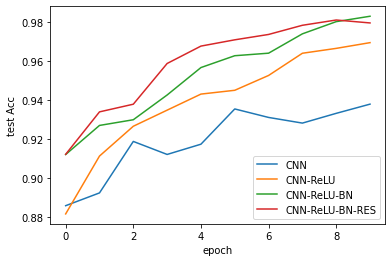

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_res_results, label="CNN-ReLU-BN-RES")

With that said, it is hard to overstate how large an impact residual connections have
had on modern deep learning, and you should almost always default to implementing a
residual-style network.